### Vcnet_V0

In [2]:
from tabular_data_framework.import_essentials import *
from tabular_data_framework.utils import *
from tabular_data_framework.utils import fix_seed
from tabular_data_framework.load_data import Load_dataset_base,load_data_dict
from tabular_data_framework.vcnet_tabular_data_v0.load_config import Load_config,load_config_dict
from tabular_data_framework.vcnet_tabular_data_v0.join_training_network import CVAE_join
from tabular_data_framework.vcnet_tabular_data_v0.train_network import Train_CVAE 
import torch 

from sklearn.metrics import pairwise_distances 
import pathlib 
import seaborn as sns 
from tabular_data_framework.metrics import *
from tabular_data_framework.plot_distributions import numpy_to_dataframe,plot_distributions
from IPython.display import Image

/Users/francoiswallyn/Desktop/ENSAI/2A/Stage/irisa/stage_irisa/test_web_stage/counterfactualViz/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### The architecture:

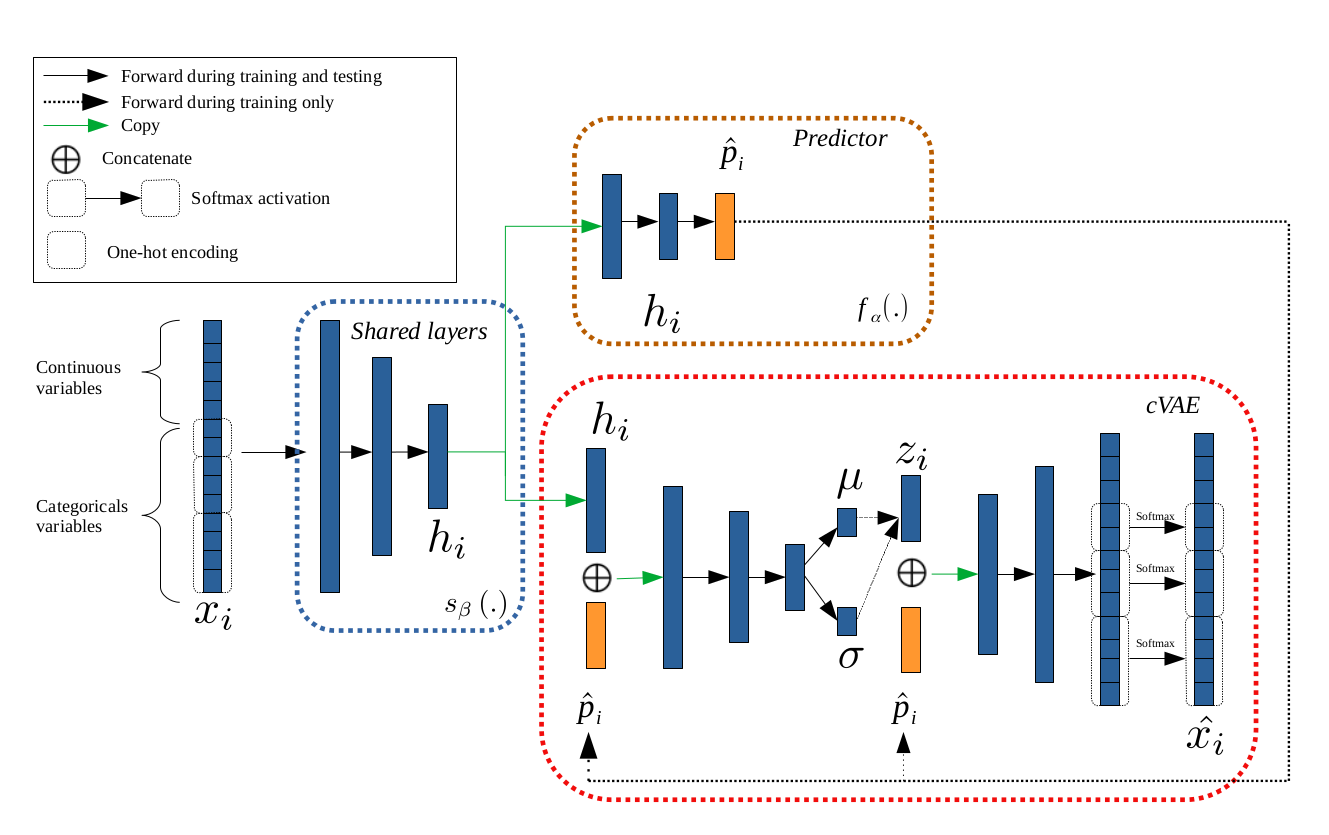

In [2]:
Image("vcnet_architecture.png",width = 600)

In [10]:
# All availaible datasets 
dataset_names = ['adult', 'student', 'home', 'churn', 'student_performance', 'titanic', 'breast_cancer', 'blobs', 'moons', 'circles']


# Dataset name to choose among dataset_names list 
name = "churn"

- Parameters of the model are stored in a .json file (vcnet_tabular_data_v0/configs/name.json) 
- Parameters for the dataset are stored in a .json file (data_configs/name.json)
- In the object Load_dataset_base is loaded all the parameters (see : load_data.py) note: this script is common for every model.
- Note that the file load_data.py contains another class named Load_dataset_carla, this class is another version of Load_dataset_base (not useful in this context), be sure that the method set_carla in used_carla.py return False to not using it.   
- If the parameter subsample is set to True, select a subsample of the test set (useful only for comparison with post-hoc counterfactual generation methods)
- prepare_data() methods run a preprocessing for the dataset
- cat_arrays contains categories of categorical variables (if no categorical variable it is an empty list)
- loaders is data loader pytorch object
- cont_shape is the number of continious variables 

In [11]:
# Load the model parameters in a dict 
model_config_dict = load_config_dict(name)
model_config = Load_config(model_config_dict)

# Load the dataset parameters in a dict 
dataset_config_dict = load_data_dict(name)
# Create a load dataset object 
dataset = Load_dataset_base(dataset_config_dict,model_config_dict,subsample=False)

# Prepare dataset and return dataloaders + ohe index 
loaders,cat_arrays,cont_shape = dataset.prepare_data()


- fix_seed is a function in utils.py to fix the all the seed (running the training multiple times will produce the same output)
- Train_CVAE is the object to train VCnet (vcnet_tabular_data_v0/train_newtork.py)
- The method train_and_valid allows to trained the model (with respected to the hyperparameters provided in the .json file), models are then stored in the directory "vcnet_tabular_data_v0/save_models"
- The parameter "tensorboard" (if set to True) allows to visualize training informations about VCnet, results are saved in "vcnet_tabular_data_v0/runs/logs folder". Run "tensorboard --logdir runs/logs" in a terminal to access informations
- ablation,condition,shared_layers are parameters to conduct ablation studies (not important for the moment, do not change these settings ) 
- cuda_name is set to "cpu" (not important,it can be config for the used of gpus)
- The method load_weights allows to load a trained model (from "vcnet_tabular_data_v0/save_models" directory) 

In [12]:
fix_seed(seed=42)

debug_enc = False 
### Prepare training 
training = Train_CVAE(dataset_config_dict,model_config_dict,cat_arrays,cont_shape,loaders,dataset,ablation=None,condition="change_dec_only",cuda_name="cpu",shared_layers=True,debug_enc=debug_enc)

#training.train_and_valid_cvae(tensorboard=True)

training.load_weights(dataset.name)

'''
X,y = dataset.test_dataset[:]

XX = training.model.forward(X,ohe=True)[0]
torch.linalg.norm(X-XX)
'''

'\nX,y = dataset.test_dataset[:]\n\nXX = training.model.forward(X,ohe=True)[0]\ntorch.linalg.norm(X-XX)\n'

In [6]:
X,y = dataset.test_dataset[:]
XX = training.model.forward(X,ohe=True)[0]
torch.linalg.norm(X-XX)

tensor(10.6206, grad_fn=<CopyBackwards>)

- The method save_post_hoc_prediction_model allows to save the predictor part of VCnet in the directory 
"post_hoc_counterfactuals/prediction_models/vcnet0/". 
The idea is to use this predictor to compare with post-hoc counterfactual generation methods

In [5]:
# Save the prediction model for comparision with post_hoc optimization methods 
training.save_post_hoc_prediction_model()

a


- Load a fix sample of the dataset X and y (defined in load_data.py), we can choose to select a subsample of this sample, it is useful for comparison with post-hoc methods
- compute_counterfactuals method it the method to generate counterfactuals, it return a dictionary that contains results (more info about it in the train_network.py script)
- Setting "laugel_metric" as True in the method add evaluation of the model on train examples in the result dictionary (needed for evaluation of the metric defined by compute_others_metrics method)
- round_counterfactuals method, round the perturbation ($\delta$ = $x_{cf}-x_{0}$) to have sparser counterfactuals. When $\delta$ is less than eps we replace the value of the counterfactual by the value of the example to explain.   It can be understand as "a change smaller than $\delta$ is equivalent to no change". This method return a dictionary of result that is the same as returned by the compute_counterfactuals method but with rounded counterfactuals and corresponding predicted classes.

In [13]:
#fix_seed(seed=42)
## Compute results 

# Select all the test data 
#X,y = dataset.test_dataset[:]
X,y = dataset.np_dataset[:]
print(X.shape)
# Select a subsample of the test data 
#X,y =  dataset.test_sample_dataset[:] 

# Compute counterfactuals 
results = training.compute_counterfactuals(X.to(training.cuda_device), y.to(training.cuda_device),laugel_metric=True)
predicted_example_class = results["y_x"].cpu().numpy()
predicted_counterfactual_class = results["y_c"].cpu().numpy()
print(results["cf"])

AttributeError: 'Load_dataset_base' object has no attribute 'np_dataset'

In [8]:
# Compute metrics 
Sparsity,Gain,Proximity,validity,diversity = compute_metrics(X,y,results,not_on_batch=True,from_numpy=False)

mean_gain = float(torch.mean(Gain))
mean_prox = float(torch.mean(Proximity))
std_gain = float(torch.std(Gain))
std_prox = float(torch.std(Proximity))
mean_sparsity =  float(torch.mean(Sparsity))
std_sparsity = float(torch.std(Sparsity))
print("Sparsity on the test set {} +/- {}:".format(round(mean_sparsity,3),round(std_sparsity,3)))
print("Validity on the test set :",float(validity))
print('Proximity on the test set {} +/- {}:'.format(round(mean_prox,3),round(std_prox,3)))
print("Gain on the test set {} +/- {}: ".format(round(mean_gain,3),round(std_gain,3)))
print("Diversity on the test set : {}".format(round(float(diversity),3)))
# Compute proximity score metric 
Proximity_laugel = compute_others_metrics(results,name,from_numpy=True)
mean_prox_laugel, std_prox_laugel = np.mean(Proximity_laugel),np.std(Proximity_laugel)
print("Proximity_laugel metric for {} dataset is {} +/- {}".format(name,str(round(mean_prox_laugel,3)),str(round(std_prox_laugel,3))))

Sparsity on the test set 6.061 +/- 2.235:
Validity on the test set : 0.8268026113510132
Proximity on the test set 4.563 +/- 2.419:
Gain on the test set 0.414 +/- 0.367: 
Diversity on the test set : 2.444
Proximity_laugel metric for adult dataset is 0.171 +/- 0.229


In [7]:
# Round counterfactuals 
eps = 0.1
results,_ = training.round_counterfactuals(results,eps,X)
results["cf"]

Percentage of valid counterfactuals : 0.9527084827423096


tensor([[0.1434, 0.3980, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.3705, 0.5477, 0.0000,  ..., 1.0000, 1.0000, 0.0000],
        [0.3734, 0.4490, 0.0000,  ..., 1.0000, 0.0000, 1.0000],
        ...,
        [0.3706, 0.5454, 0.0000,  ..., 1.0000, 0.0000, 1.0000],
        [0.3643, 0.5579, 0.0000,  ..., 1.0000, 0.0000, 1.0000],
        [0.3973, 0.5538, 1.0000,  ..., 1.0000, 0.0000, 1.0000]])

Impact of epsilon for each metric:

In [8]:
Eps = np.linspace(0,0.4,100)
Eps

array([0.        , 0.0040404 , 0.00808081, 0.01212121, 0.01616162,
       0.02020202, 0.02424242, 0.02828283, 0.03232323, 0.03636364,
       0.04040404, 0.04444444, 0.04848485, 0.05252525, 0.05656566,
       0.06060606, 0.06464646, 0.06868687, 0.07272727, 0.07676768,
       0.08080808, 0.08484848, 0.08888889, 0.09292929, 0.0969697 ,
       0.1010101 , 0.10505051, 0.10909091, 0.11313131, 0.11717172,
       0.12121212, 0.12525253, 0.12929293, 0.13333333, 0.13737374,
       0.14141414, 0.14545455, 0.14949495, 0.15353535, 0.15757576,
       0.16161616, 0.16565657, 0.16969697, 0.17373737, 0.17777778,
       0.18181818, 0.18585859, 0.18989899, 0.19393939, 0.1979798 ,
       0.2020202 , 0.20606061, 0.21010101, 0.21414141, 0.21818182,
       0.22222222, 0.22626263, 0.23030303, 0.23434343, 0.23838384,
       0.24242424, 0.24646465, 0.25050505, 0.25454545, 0.25858586,
       0.26262626, 0.26666667, 0.27070707, 0.27474747, 0.27878788,
       0.28282828, 0.28686869, 0.29090909, 0.29494949, 0.29898

In [6]:
# Range of epsilon
Eps = np.linspace(0,0.4,100)
# Dataframe of metrics values for each value of epsilon 
df = pd.DataFrame(columns=["Eps","Validity","Proximity","Prediction_gain","Proximity_score","Sparsity","Diversity"])
df["Eps"] = Eps
for i,eps in enumerate(Eps) : 
    # Compute counterfactuals
    results = training.compute_counterfactuals(X.to(training.cuda_device), y.to(training.cuda_device),laugel_metric=True)
    # Round results
    results,_ = training.round_counterfactuals(results,eps,X)
    # Compute metrics 
    Sparsity,Gain,Proximity,validity,diversity = compute_metrics(X,y,results,not_on_batch=True,from_numpy=False)
    
    # Compute proximity score metric 
    Proximity_laugel = compute_others_metrics(results,name,from_numpy=True)
    mean_prox_laugel = np.mean(Proximity_laugel)
    
    
    # Write result for each line 
    df.loc[i] = pd.Series({"Eps" : Eps[i],"Validity" : round(float(validity),3),"Proximity" : round(float(torch.mean(Proximity)),3),
                           "Prediction_gain" : round(float(torch.mean(Gain)),3),
                           "Proximity_score" : round(mean_prox_laugel,3), "Sparsity" : round(float(torch.mean(Sparsity)),3),
                           "Diversity" : round(float(diversity),3)}) 

# Save the dataframe 
df.to_csv("vcnet_tabular_data_v0/save_metrics/results_rounding_threshold/" + "results_rounding_for{}_dataset.csv".format(dataset.name))

Percentage of valid counterfactuals : 0.9995091557502747
Percentage of valid counterfactuals : 0.9997545480728149
Percentage of valid counterfactuals : 0.9991409778594971
Percentage of valid counterfactuals : 0.9991409778594971


KeyboardInterrupt: 

In [51]:
df = pd.read_csv("vcnet_tabular_data_v0/save_metrics/results_rounding_threshold/" + "results_rounding_for{}_dataset.csv".format(dataset.name))

df[df["Eps"] < 0.1 ].std()

Unnamed: 0         7.359801
Eps                0.029737
Validity           0.024281
Proximity          0.190594
Prediction_gain    0.025801
Proximity_score    0.005553
Sparsity           0.316351
Diversity          0.017977
dtype: float64

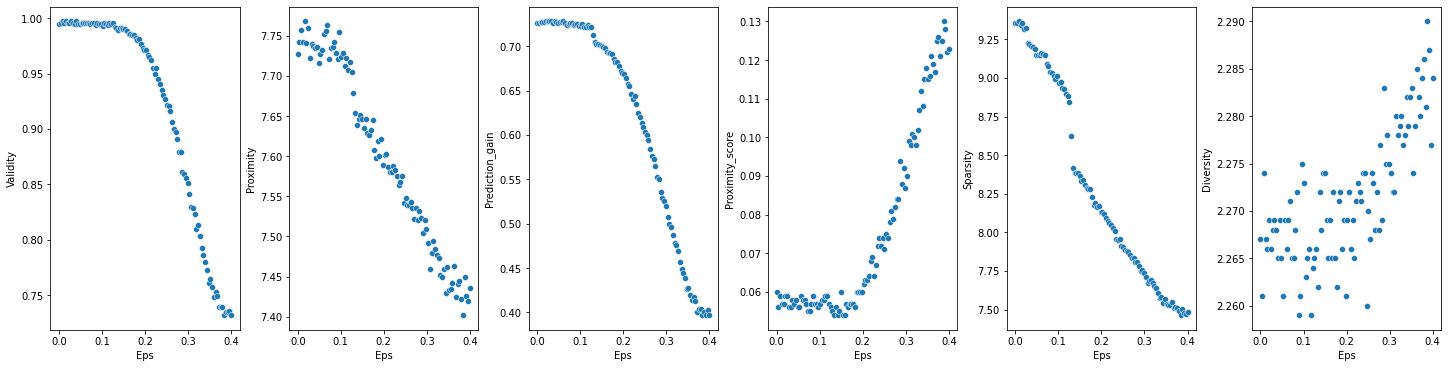

In [20]:
import seaborn as sns
df = pd.read_csv("vcnet_tabular_data_v0/save_metrics/results_rounding_threshold/" + "results_rounding_for{}_dataset.csv".format(dataset.name))

Metrics = ["Validity","Proximity","Prediction_gain","Proximity_score","Sparsity","Diversity"]

fig, axs = plt.subplots(1,6, figsize=(20, 5),constrained_layout=True)
c = 0

for i in range(axs.shape[0]) :
    ax = sns.scatterplot(data=df, x="Eps", y=Metrics[c],ax=axs[i])
    c+=1 
    

Pass mean predicted probability on test as input in the decoder at inference ($p_c$):

In [ ]:
fix_seed()
## Compute results 

# Select all the test data 
X,y = dataset.test_dataset[:]

# Predicted proba for test examples 
proba_test = training.model.forward_pred(X)


'''# Compute counterfactuals 
results = training.compute_counterfactuals(X.to(training.cuda_device), y.to(training.cuda_device),laugel_metric=True)
predicted_example_class = results["y_x"].cpu().numpy()
predicted_counterfactual_class = results["y_c"].cpu().numpy()
print(results["cf"])'''

# Mean predicted probability for each predicted class 
P_i_1 = float(torch.mean(proba_test[np.where(proba_test > 0.5)]))
P_i_0 = float(torch.mean(proba_test[np.where(proba_test < 0.5)]))

# Input is mean proba for class 0 if predicted class 1 else 1 
proba_input = ((proba_test < 0.5).int()) * P_i_1 + ((proba_test > 0.5).int()) * P_i_0


# Compute counterfactuals 
results = training.compute_counterfactuals_custom_proba(X.to(training.cuda_device), y.to(training.cuda_device),proba_input.to(training.cuda_device),laugel_metric=True)
predicted_example_class = results["y_x"].cpu().numpy()
predicted_counterfactual_class = results["y_c"].cpu().numpy()

# Round counterfactuals 
eps = 0.01
results = training.round_counterfactuals(results,eps,X)
results["cf"]


Experiments to discuss changes between multiple counterfactuals sets : 
 - Bar plot of mean number of changes per seed :

In [6]:
np.random.seed(3)
# Select 10 seed
number_of_seed = 10
S = np.random.choice(78,number_of_seed,replace=False)

In [39]:
# Mean pairwise distance for different runs 
Results_runs = np.zeros((S.shape[0],X.shape[0],X.shape[1]))
i=0
for seed in S : 
    fix_seed(seed=seed) 
    # Compute counterfactuals 
    results = training.compute_counterfactuals(X.to(training.cuda_device), y.to(training.cuda_device),laugel_metric=True)
    predicted_example_class = results["y_x"].cpu().numpy()
    predicted_counterfactual_class = results["y_c"].cpu().numpy()
    Results_runs[i] = results["cf"]
    i+=1

In [40]:
# For each example 
Var = []
for ind_ex in range(Results_runs.shape[1]) : 
    Matrix = np.zeros((Results_runs[:,ind_ex].shape[0],Results_runs[:,ind_ex].shape[0]))
    for i in range(Matrix.shape[0]) : 
        for j in range(i+1,Matrix.shape[1]) : 
            C1 = Results_runs[:,ind_ex][i]
            C2 = Results_runs[:,ind_ex][j]
            # Change for numerical and categorical 
            number_continous = len(dataset.continous_cols)
            # Change for numerical if change > 0.1 and change for categorical is divided by 2 (2 changes in onehot=1change)
            Matrix[i,j] = int(np.sum(np.abs(C1[:number_continous]-C2[:number_continous]) > 0.1)) + int(np.sum(np.abs(C1[number_continous:] - C2[number_continous:])) / 2)
    # Mean number of change
    Var.append(np.mean(Matrix[np.where(Matrix!=0)]))

Text(0.5, 1.0, 'Number of changes for 10 seeds')

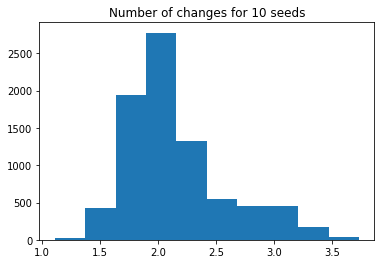

In [41]:
plt.hist(Var)
plt.title("Number of changes for {} seeds".format(number_of_seed))

Predictor performances:

In [81]:
# Performances on the test set 

pred_proba = training.model.forward_pred(X).squeeze(1).detach().numpy()
pred_class = np.round(pred_proba)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print("AUC on test is : {}".format(round(roc_auc_score(y,pred_proba),2)))
print("Accuracy on test is : {}".format(round(accuracy_score(y,pred_class),2)))
confusion_matrix(y, pred_class)

AUC on test is : 0.88
Accuracy on test is : 0.83


array([[5785,  407],
       [ 954,  995]])

Metric to evaluate score differences between counterfactuals and desired score :

In [8]:
'''E = []
for p in [x * 0.1 for x in range(0, 11)]:
        proba = torch.tensor([[p for i in range(X.shape[0])]]).T
        # Compute counterfactuals 
        results = training.compute_counterfactuals_custom_proba(X.to(training.cuda_device), y.to(training.cuda_device),proba=proba,laugel_metric=False)
        error = torch.linalg.norm(results["proba_c"]-proba.T)
        E.append(error)
print("Mean error : {} ".format(np.mean(E)))
print("Std error : {}".format(np.std(E)))'''

'E = []\nfor p in [x * 0.1 for x in range(0, 11)]:\n        proba = torch.tensor([[p for i in range(X.shape[0])]]).T\n        # Compute counterfactuals \n        results = training.compute_counterfactuals_custom_proba(X.to(training.cuda_device), y.to(training.cuda_device),proba=proba,laugel_metric=False)\n        error = torch.linalg.norm(results["proba_c"]-proba.T)\n        E.append(error)\nprint("Mean error : {} ".format(np.mean(E)))\nprint("Std error : {}".format(np.std(E)))'

- Metric are computed from a common script between all the methods (metrics.py)
- from_numpy parameter is set to False because the model is a pytorch model

In [82]:
# Compute metrics 
Sparsity,Gain,Proximity,validity,diversity = compute_metrics(X,y,results,not_on_batch=True,from_numpy=False)

mean_gain = float(torch.mean(Gain))
mean_prox = float(torch.mean(Proximity))
std_gain = float(torch.std(Gain))
std_prox = float(torch.std(Proximity))
mean_sparsity =  float(torch.mean(Sparsity))
std_sparsity = float(torch.std(Sparsity))
print("Sparsity on the test set {} +/- {}:".format(round(mean_sparsity,3),round(std_sparsity,3)))
print("Validity on the test set :",float(validity))
print('Proximity on the test set {} +/- {}:'.format(round(mean_prox,3),round(std_prox,3)))
print("Gain on the test set {} +/- {}: ".format(round(mean_gain,3),round(std_gain,3)))
print("Diversity on the test set : {}".format(round(float(diversity),3)))
# Compute proximity score metric 
Proximity_laugel = compute_others_metrics(results,name,from_numpy=True)
mean_prox_laugel, std_prox_laugel = np.mean(Proximity_laugel),np.std(Proximity_laugel)
print("Proximity_laugel metric for {} dataset is {} +/- {}".format(name,str(round(mean_prox_laugel,3)),str(round(std_prox_laugel,3))))

Sparsity on the test set 2.75 +/- 1.354:
Validity on the test set : 0.44785651564598083
Proximity on the test set 1.335 +/- 1.49:
Gain on the test set 0.057 +/- 0.352: 
Diversity on the test set : 2.618
Proximity_laugel metric for adult dataset is 0.177 +/- 0.23


- Distribution plot to visualize counterfactuals (see plot_distributions.py functions)
- Not availaible for "blobs" dataset 

<Figure size 432x288 with 0 Axes>

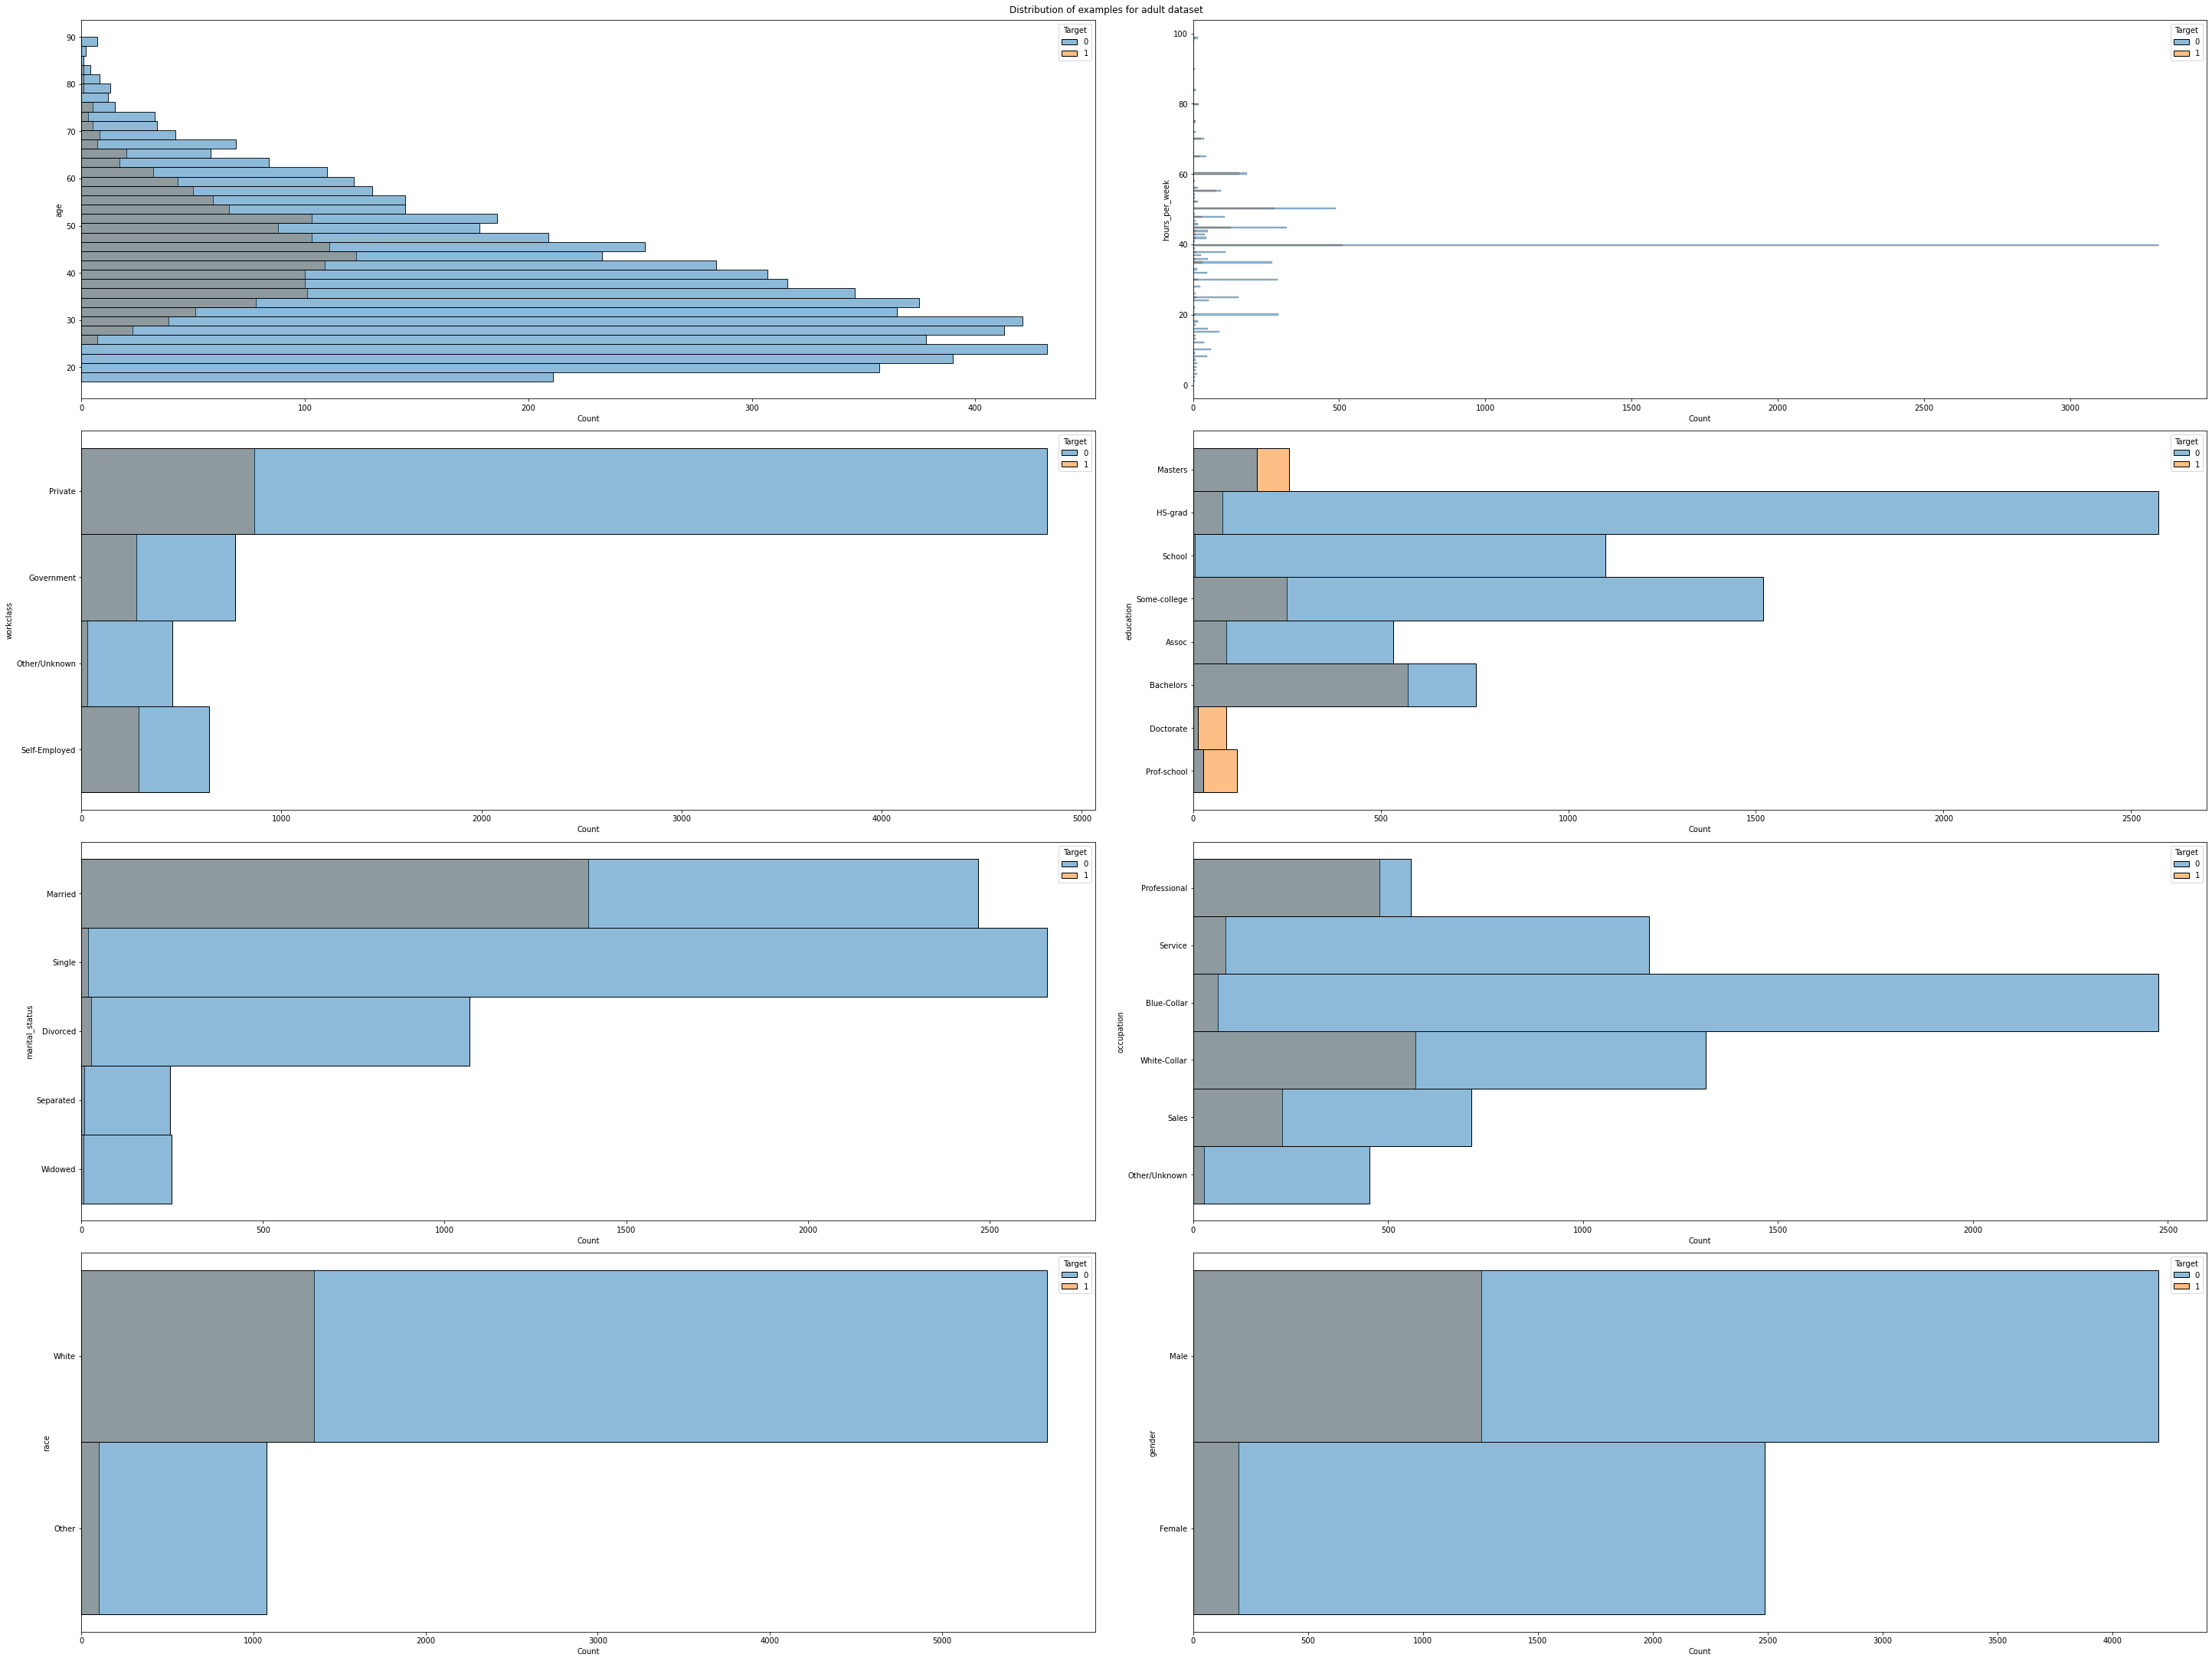

<Figure size 432x288 with 0 Axes>

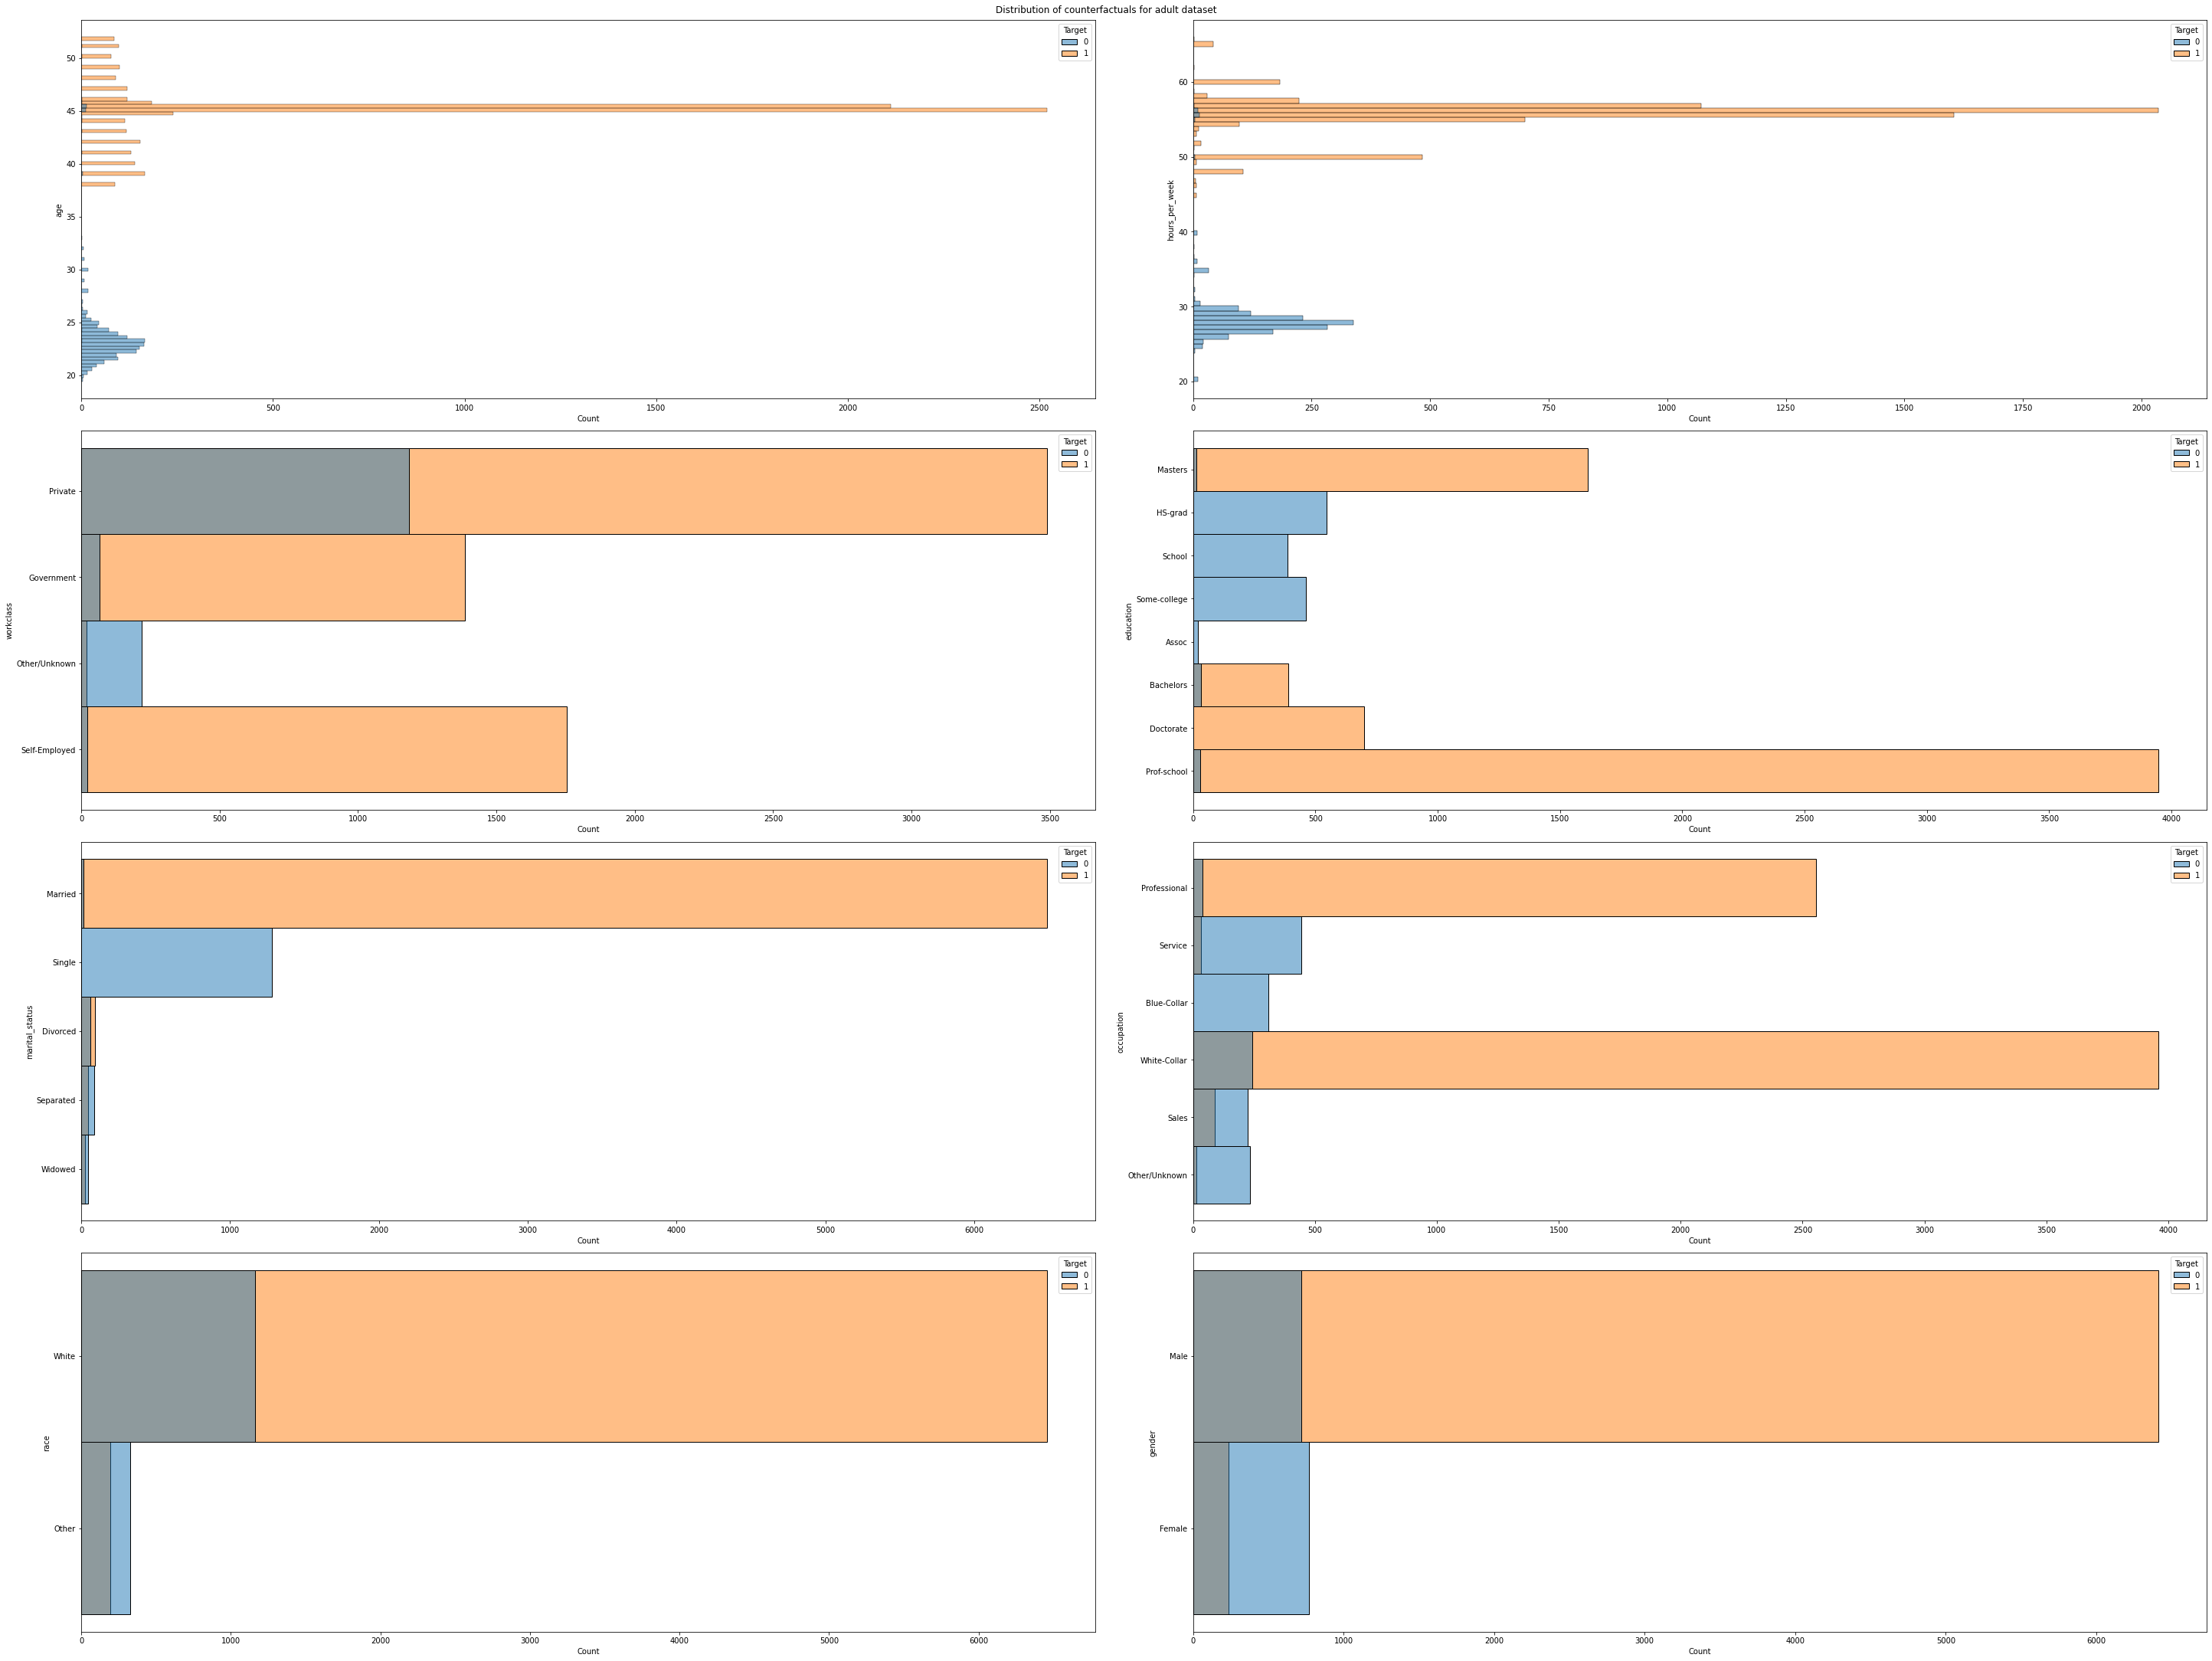

In [223]:
original_examples,original_counterfactuals = numpy_to_dataframe(X,results["cf"],dataset)


#Plot distributions for each target values 
original_examples_target,original_counterfactuals_target = original_examples.copy(),original_counterfactuals.copy()
original_examples_target["Target"] = predicted_example_class
original_counterfactuals_target["Target"] = predicted_counterfactual_class 

plt.figure()
plot_distributions(name,original_examples_target,counterfactual=False,hue=True)
plt.figure()
plot_distributions(name,original_counterfactuals_target,counterfactual=True,hue=True)

- The function round_counterfactuals in utils.py file, compute examples and counterfactuals rounded values for type int variables and the corresponding predictions, it also check if inverse transforming examples to explain gave the same results (inverse_transform(transform(X)) == X). It gave an alert if rounding change the predicted class of counterfactuals. It return a dictionary that contains dataframes of examples and counterfactuals, it containts also predicted probabilities, and predicted classes. 

In [12]:
# Round numerical values and check if counterfactuals are still valid 
from utils import check_min_max_scaler,int_round_dataset,round_counterfactuals
# dico of columns we want as rounded variables (here rounded is done to obtain int)
#dico_round = {"tenure" : None, "MonthlyCharges" : 2, "TotalCharges" : 2 }
dico_round = {"age" : 1, "hours_per_week" : 1 }
results_rounded = round_counterfactuals(X,results,dataset,training,dico_round)
# Add true labels
results_rounded["y_true_x"] = y 

# Train data to compute laugel metric 
results_rounded["x_train"] = results["x_train"]
results_rounded["y_x_train"] = results["y_x_train"]

Compute metrics for rounded counterfactuals :  

In [11]:
# Compute metrics 
Sparsity,Gain,Proximity,validity,diversity = compute_metrics(X,y,results_rounded,not_on_batch=True,from_numpy=False)

mean_gain = float(torch.mean(Gain))
mean_prox = float(torch.mean(Proximity))
std_gain = float(torch.std(Gain))
std_prox = float(torch.std(Proximity))
mean_sparsity =  float(torch.mean(Sparsity))
std_sparsity = float(torch.std(Sparsity))
print("Sparsity on the test set {} +/- {}:".format(round(mean_sparsity,3),round(std_sparsity,3)))
print("Validity on the test set :",float(validity))
print('Proximity on the test set {} +/- {}:'.format(round(mean_prox,3),round(std_prox,3)))
print("Gain on the test set {} +/- {}: ".format(round(mean_gain,3),round(std_gain,3)))
print("Diversity on the test set : {}".format(round(float(diversity),3)))
# Compute proximity score metric 
Proximity_laugel = compute_others_metrics(results,name,from_numpy=True)
mean_prox_laugel, std_prox_laugel = np.mean(Proximity_laugel),np.std(Proximity_laugel)
print("Proximity_laugel metric for {} dataset is {} +/- {}".format(name,str(round(mean_prox_laugel,3)),str(round(std_prox_laugel,3))))

NameError: name 'results_rounded' is not defined

#### Final Results to json for interface :

In [11]:
def result_to_d3(result:Dict):
    data = {}
    data["col"] = result["X"].columns.tolist()
    data["X"] = result["X"].values.transpose().tolist()
    data["cf"] = result["cf"].values.transpose().tolist()
    data["y_x"] = result["y_x"].cpu().tolist()
    data["y_c"] = result["y_c"].cpu().tolist()
    data["proba_x"] = result["proba_x"].cpu().tolist()
    data["proba_c"] = result["proba_c"].cpu().tolist()
    return data


'''
import json
with open('data_churn.json', 'w') as fp:
    data = result_to_d3(results_round_sample)
    json.dump(data, fp)''' 




def proba_results_to_d3():
    data_prob = {}
    for p in [x * 0.1 for x in range(0, 11)]:
        proba = torch.tensor([[p for i in range(X.shape[0])]]).T
        # Compute counterfactuals 
        results = training.compute_counterfactuals_custom_proba(X.to(training.cuda_device), y.to(training.cuda_device),proba=proba,laugel_metric=False)
        predicted_example_class = results["y_x"].cpu().numpy()
        predicted_counterfactual_class = results["y_c"].cpu().numpy()

        '''# Round counterfactuals 
        eps = 0.1
        results = training.round_counterfactuals(results,eps,X)'''

        # Round numerical values and check if counterfactuals are still valid 
        from utils import check_min_max_scaler,int_round_dataset,round_counterfactuals
        # dico of columns we want as rounded variables (here rounded is done to obtain int)
        dico_round = {"tenure" : None, "MonthlyCharges" : 2, "TotalCharges" : 2 }
        results_rounded = round_counterfactuals(X,results,dataset,training,dico_round)
        data_prob[f"{round(p,1)}"] = result_to_d3(results_rounded)
    return data_prob

import json
with open('data_churn_probs.json', 'w') as fp:
    data = proba_results_to_d3()
    json.dump(data, fp)

Alert : Some class have changed after rounding
99.94% of counterfactuals are still valid
Alert : Some class have changed after rounding
99.89% of counterfactuals are still valid
Alert : Some class have changed after rounding
99.60% of counterfactuals are still valid
Alert : Some class have changed after rounding
99.20% of counterfactuals are still valid
Alert : Some class have changed after rounding
99.49% of counterfactuals are still valid
Alert : Some class have changed after rounding
99.66% of counterfactuals are still valid
Alert : Some class have changed after rounding
99.89% of counterfactuals are still valid
Alert : Some class have changed after rounding
99.89% of counterfactuals are still valid
Alert : Some class have changed after rounding
99.89% of counterfactuals are still valid


### Visualisation on blobs:

- Save results in the case of blobs dataset for visualization in the script "vcnet_tabular_data_v0/VCnet_blobs_visualization.ipynb "

In [8]:
# Save results for 2D plot  
training.save_for_plot_toy()
 
training.save_contourf_for_plot()

### Hyperparameter visualization: 

In [22]:
import joblib 
study = joblib.load("vcnet_tabular_data_v0/studies/study_churn.pkl")
study.trials_dataframe()

,number,values_0,values_1,values_2,values_3,datetime_start,datetime_complete,duration,params_batch_size,params_epochs,params_lambda_1,params_lambda_2,params_lambda_3,params_latent_size,params_learning_rate,params_mide_reduce_size,system_attrs_nsga2:generation,system_attrs_nsga2:parents,state
0,0,0.794653,0.977247,0.534236,19.026480,2022-06-27 16:46:12.297149,2022-06-27 16:46:47.651541,0 days 00:00:35.354392,113,103,0.043,0.935,0.0009,36,0.000082,49,0,NaN,COMPLETE
1,1,0.803185,0.990330,0.598825,19.706358,2022-06-27 16:46:47.651835,2022-06-27 16:48:08.378072,0 days 00:01:20.726237,60,246,0.370,0.450,0.0001,5,0.000114,243,0,NaN,COMPLETE
2,2,0.808305,0.992605,0.611686,19.571510,2022-06-27 16:48:08.378355,2022-06-27 16:49:35.064365,0 days 00:01:26.686010,120,243,0.669,0.374,0.0007,11,0.000268,127,0,NaN,COMPLETE
3,3,0.802617,0.994312,0.605846,19.825378,2022-06-27 16:49:35.064770,2022-06-27 16:50:26.182336,0 days 00:00:51.117566,63,178,0.601,0.450,0.0009,16,0.000062,140,0,NaN,COMPLETE
4,4,0.800341,0.973834,0.602525,19.393509,2022-06-27 16:50:26.182620,2022-06-27 16:51:32.639828,0 days 00:01:06.457208,95,214,0.118,0.559,0.0002,3,0.000585,208,0,NaN,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,0.795222,0.902730,0.447029,18.861126,2022-06-28 09:10:32.104769,2022-06-28 09:11:42.106400,0 days 00:01:10.001631,37,76,0.802,0.323,0.0001,37,0.000077,139,9,"[371, 301]",COMPLETE
496,496,0.798066,0.957338,0.496347,19.055840,2022-06-28 09:11:42.106911,2022-06-28 09:15:40.043771,0 days 00:03:57.936860,116,236,0.006,0.379,0.0007,22,0.000016,126,9,"[72, 279]",COMPLETE
497,497,0.803185,0.967577,0.565767,19.471794,2022-06-28 09:15:40.044281,2022-06-28 09:20:12.321029,0 days 00:04:32.276748,73,235,0.338,0.040,0.0005,33,0.000537,167,9,"[200, 159]",COMPLETE
498,498,0.803754,0.981229,0.592233,19.412842,2022-06-28 09:20:12.321547,2022-06-28 09:24:04.140060,0 days 00:03:51.818513,58,235,0.043,0.973,0.0004,34,0.000502,110,9,"[374, 359]",COMPLETE


### Latent space visualization with a 2dim size:

In [14]:
# Pass examples in the latent space
def compute_for_plot(X) : 
   # Pass examples in the latent space 
    vcnet_model = training.model
    vcnet_model.eval()
    _,mu,logvar,output_class = vcnet_model.forward(X)
    z = vcnet_model.reparameterize(mu,logvar).detach().numpy()
    y_pred = torch.round(output_class).long().int()
    plot_data = pd.DataFrame(data=np.hstack((z,y_pred)),columns=["z1","z2","Predicted_class"])
    plot_data["Predicted_class"] = plot_data["Predicted_class"].astype(int)
    plot_data["z3"] = output_class.detach().numpy()
    return(plot_data)

    

# Plot z1,z2 

def plot_2d(plot_data,coord,hue="Predicted_class") : 
    sns.scatterplot(data=plot_data, x=coord[0], y=coord[1], hue=hue)
    ax = plt.gca()
    ax.set_title("Latent space of size 2 for {} dataset".format(dataset.name))


# Plot 3d (z1,z2,output_class) 
from mpl_toolkits.mplot3d import Axes3D
def plot_3d(plot_data,label,fig) : 
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    cdict = {1: 'C0', 0: 'C1'}
    for e in np.unique(plot_data[label]) : 
        ind = np.where(plot_data[label]==e)
        sc = ax.scatter(plot_data["z1"].loc[ind], plot_data["z2"].loc[ind], plot_data["z3"].loc[ind], s=40, color=cdict[e], marker='o',label="Predicted class {}".format(int(e)))
    ax.set_xlabel('z1')
    ax.set_ylabel('z2')
    ax.set_zlabel('Output score')
    ax.legend()
    plt.title("Latent space visualization with output score")

Latent space plot for train examples : 

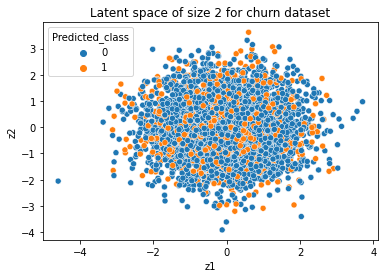

In [15]:
# Latent size plot (z1,z2) with train examples 
fix_seed()
X_train,y_train = dataset.train_dataset[:]
plot_data = compute_for_plot(X_train)
plot_2d(plot_data,["z1","z2"]) 

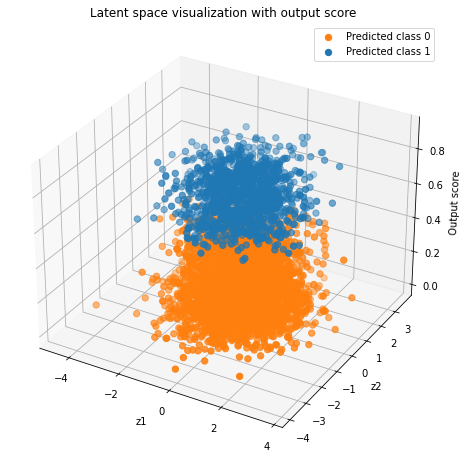

In [10]:
# Latent space 3d plot for train examples (z1,z2,output_class)
fix_seed()
fig = plt.figure(figsize=(6,6))
plot_3d(plot_data,"Predicted_class",fig)

Latent space plot for counterfactuals : 

In [34]:
# Latent space representation for counterfactuals 
z_c = results["z"]
# Proba pass at the input 
p_c = (1 - results["y_x"]).unsqueeze(1)
plot_data_c = pd.DataFrame(data=np.hstack((z_c,p_c)),columns=["z1","z2","z3"])
# Predicted class for counterfactuals
plot_data_c["Predicted_class"] = results["y_c"]
plot_data_c["Predicted_class"] = plot_data_c["Predicted_class"].astype(int)

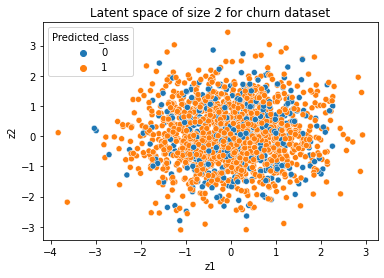

In [35]:
# Latent size plot (z1,z2) with counterfactuals 
fix_seed()
plot_2d(plot_data,["z1","z2"]) 

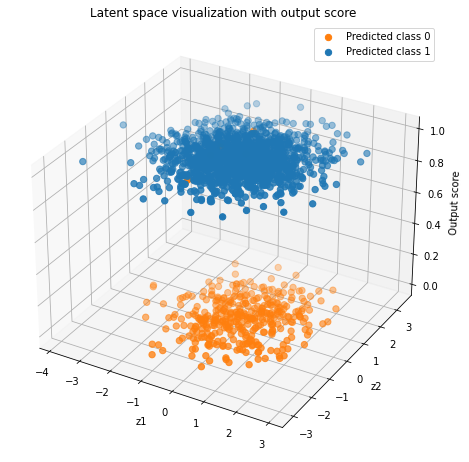

In [36]:
# Latent space 3d plot for counterfactuals
fix_seed()
fig = plt.figure(figsize=(6,6))
plot_3d(plot_data,"Predicted_class",fig)

Latent space with counterfactuals and examples as label :

In [26]:
# Latent space representation for counterfactuals 
z_c = results["z"]
# Proba pass at the input 
p_c = (1 - results["y_x"]).unsqueeze(1)
plot_data_c = pd.DataFrame(data=np.hstack((z_c,p_c)),columns=["z1","z2","p_c"])
# Predicted class for counterfactuals
plot_data_c["Predicted_class"] = results["y_c"]
plot_data_c["Predicted_class"] = plot_data_c["Predicted_class"].astype(int)
# Proba pass for X 
p_i = results["proba_x"]
plot_data_c["p_x"] = p_i

In [29]:
plot_data_c

,z1,z2,p_c,Predicted_class,p_x
0,-0.181933,-0.324395,1.0,1,0.269376
1,0.761986,-0.941995,0.0,0,0.597229
2,-0.643372,1.207358,1.0,1,0.008297
3,-1.287264,-0.610499,0.0,0,0.504725
4,0.699488,0.995579,1.0,1,0.162822
...,...,...,...,...,...
1753,-0.382820,0.604741,1.0,1,0.108592
1754,-0.517890,-0.526172,1.0,1,0.172257
1755,-1.013181,-2.036425,1.0,1,0.271137
1756,1.009103,1.391974,0.0,0,0.713223


Text(0.5, 0.92, 'Latent space visualization with output score')

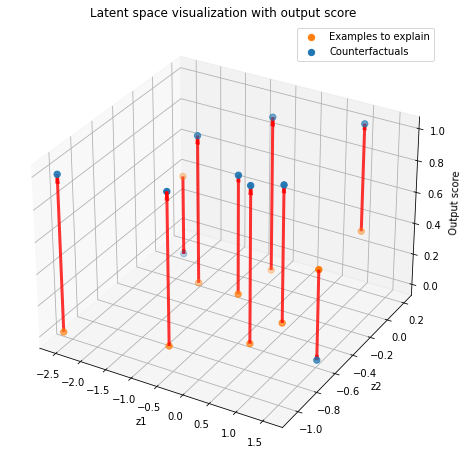

In [33]:
# Latent size plot (z1,z2,output_class) with counterfactual examples
fix_seed()
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
cdict = {1: 'C0', 0: 'C1'}

sample = np.random.choice(len(plot_data_c),10)

sc = ax.scatter(plot_data_c["z1"].loc[sample], plot_data_c["z2"].loc[sample], plot_data_c["p_x"].loc[sample], s=40, color=cdict[0], marker='o',label="Examples to explain")
sc = ax.scatter(plot_data_c["z1"].loc[sample], plot_data_c["z2"].loc[sample], plot_data_c["p_c"].loc[sample], s=40, color=cdict[1], marker='o',label="Counterfactuals")

# 3d Arrow between examples and counterfactuals for a subsample  
for s in sample :
    #arw = Arrow3D([plot_data_ex["z1"].loc[s],plot_data_c["z1"].loc[s]],[plot_data_ex["z2"].loc[s],plot_data_c["z2"].loc[s]],[plot_data_ex["z3"].loc[s],plot_data_c["z3"].loc[s]], arrowstyle="->", color="purple", lw = 3, mutation_scale=25)
    #ax.add_artist(arw)

    ax.quiver(plot_data_c["z1"].loc[s],plot_data_c["z2"].loc[s],plot_data_c["p_x"].loc[s],
          plot_data_c["z1"].loc[s]-plot_data_c["z1"].loc[s],
          plot_data_c["z2"].loc[s]-plot_data_c["z2"].loc[s],
          plot_data_c["p_c"].loc[s]-plot_data_c["p_x"].loc[s],color="red", alpha = .8, lw = 3,arrow_length_ratio=0.06)

ax.set_xlabel('z1')
ax.set_ylabel('z2')
ax.set_zlabel('Output score')
ax.legend()
plt.title("Latent space visualization with output score")

#### Compute counterfactuals for a given probability threeshold : 

In [113]:
fix_seed()

# Select all the test data 
X,y = dataset.test_dataset[:]

# Probability vector (choose a proba threeshold)
proba = torch.tensor([[0.8 for i in range(X.shape[0])]]).T

# Compute counterfactuals 
results = training.compute_counterfactuals_custom_proba(X.to(training.cuda_device), y.to(training.cuda_device),proba=proba,laugel_metric=True)
predicted_example_class = results["y_x"].cpu().numpy()
predicted_counterfactual_class = results["y_c"].cpu().numpy()
print(results["cf"])


# Round counterfactuals 
eps = 0.1
results = training.round_counterfactuals(results,eps,X)

# Round numerical values and check if counterfactuals are still valid 
from utils import check_min_max_scaler,int_round_dataset,round_counterfactuals
# dico of columns we want as rounded variables (here rounded is done to obtain int)
dico_round = {"tenure" : None, "MonthlyCharges" : None, "TotalCharges" : None }
results_rounded = round_counterfactuals(X,results,dataset,training,dico_round)
results_rounded

tensor([[0.0000, 0.6754, 0.0585,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.6071, 0.0294,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.6305, 0.0147,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.0000, 0.6136, 0.0184,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.6670, 0.0317,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.6525, 0.0090,  ..., 0.0000, 1.0000, 0.0000]])
Percentage of counterfactuals that are not still valid : 0.003412961959838867


{'X':       tenure  MonthlyCharges  TotalCharges  gender SeniorCitizen Partner  \
 0         19              49           954  Female             0      No   
 1          5              46           198  Female             1      No   
 2         71              81          5705  Female             0     Yes   
 3          8              75           610    Male             0     Yes   
 4          1              21            21    Male             0      No   
 ...      ...             ...           ...     ...           ...     ...   
 1753      24              85          1990    Male             0     Yes   
 1754      72             103          7363  Female             0     Yes   
 1755      11              30           346  Female             0     Yes   
 1756       4              74           307    Male             1     Yes   
 1757      66             106          6844    Male             0      No   
 
      Dependents PhoneService     MultipleLines InternetService  \
 0